# **Pattern Recognition: Assignment 1 - Question 1**

Submitted by: 

Abhishek Tandon (S22002)

MTech (by Research) - Intelligent Systems, SCEE

###Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math

###Mount G-Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive')
# %ls


Mounted at /content/drive




## **Short-Time Energy (STE)**

###Read Data

In [3]:
path = '/content/drive/MyDrive/assign1_data/q1'

# read data from mounted GDrive
# header = None is used so that first row is not skipped by DataFrame

def split_data(X, ground_truth):
    # use masking to separate data class-wise (speech and non-speech)

    speech = X[ground_truth == 1]
    non_speech = X[ground_truth == 0]

    return speech, non_speech

# training data

X_STE = pd.read_csv(path+'/Segment2_STEnergy.csv', header = None)
ground_truth_train = pd.read_csv(path+'/Segment2_VAD_GT.csv', header = None)

X_train = np.array(X_STE)
speech_train, non_speech_train = split_data(X_train, ground_truth_train)

speech_train.shape, non_speech_train.shape


((111,), (145,))

###Calculate Mean and Variance for each class

$$ \,\,\,mean:\,\,\bar{x} = \frac{∑_{1}^{n} x_i}{N}$$


$$ \,\,variance:\,\,\sigma^{2} = \frac{∑_{1}^{n} (x_i-\bar{x})^{2}}{N}$$


In [4]:
# calculate mean and variance for sample data of speech and non-speech separately

def mean_var(data):
    n = np.size(data)

    mean = np.sum(data)/n
    var = np.sum((data - mean) ** 2)/n

    return (mean, var)

# mean and variance for both the classes
mu1, var1 = mean_var(speech_train)
mu2, var2 = mean_var(non_speech_train)

# standard deviation 
sd1 = math.sqrt(var1)
sd2 = math.sqrt(var2)

print("Mean, Variance and Standard Deviation for: \n")
print("Speech Training Data - ", mu1, ", ", var1, ", ", sd1)
print("Non-Speech Training Data - ", mu2, ", ", var2, ", ", sd2)



Mean, Variance and Standard Deviation for: 

Speech Training Data -  0.12043432332432433 ,  0.027681259243278893 ,  0.16637685909788924
Non-Speech Training Data -  0.053090674108275865 ,  0.0012944035189149682 ,  0.03597781981881293


###Estimate Normal Curve for Each Class

$$ P(x|class) \sim N(\mu_2, \sigma) = \frac{1}{\sqrt[]{2\pi\sigma}}\exp\Biggl[\frac{-1}{2} \biggr( \frac{x-\bar{x}}{\sigma} \biggl)^2 \Biggr]$$

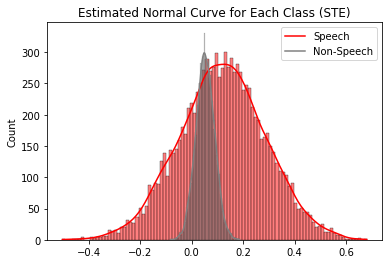

In [5]:
# estimate a normal curve based on the mean and variance of the sample data

val1 = np.random.normal(mu1, sd1, 10000)
val2 = np.random.normal(mu2, sd2, 10000)

sb.histplot(val1, kde=True, bins = 100, color = "red")
sb.histplot(val2, kde=True, bins = 100, color = "gray")

plt.title("Estimated Normal Curve for Each Class (STE)")
plt.legend(["Speech", "Non-Speech"])
plt.show()


###Calculate Liklihood, Prior and Posterior Probabilities

In [6]:
# use mean and variance of each class

def likelihood(mu, sigma, x):
    prob_x_given_class = ( 1 / ( math.sqrt(2 * math.pi) * sigma ) ) * math.e ** ( (-0.5) * ( (x - mu) / sigma )**2 )
    return prob_x_given_class

def prior(x, X):
    # prior for each class = number of data points that belong to that class / total number of data points
    return np.divide(x.size, X.size)

# use Bayes' Theorem to calculate posterior probability
def posterior(likelihood, prior, evidence):
    posterior = np.divide((likelihood * prior), evidence)
    return posterior


###Test the Model

######Use Baye's Theorem

$$ P(speech|x) = \frac{P(x|speech) \, P(speech)}{P(x|speech) \, P(speech) + P(x|nonSpeech) \, P(nonSpeech)}; \, \, where\, \, \, \,  x \, \, = \, test\,data $$



In [7]:
X_test = pd.read_csv(path+'/Segment3_STEnergy.csv', header = None)

# Ground Truth to test the model
ground_truth_test = pd.read_csv(path+'/Segment3_VAD_GT.csv', header = None)

# Using Numpy's array broadcast to calculate all the values in one go

# calculate likelihood: required in Baye's formula 

# P(x|class1) or P(new datapoint|speech)
prob_x_given_speech = likelihood(mu1, sd1, X_test) # probability that the new data point belong to speech class

# probability that new data point belongs to non-speech class
# P(x|class2) or P(new datapoint|non-speech)
prob_x_given_non_speech = likelihood(mu2, sd2, X_test) 

# calculate prior probability for each class
# P(speech) and P(non-speech) 
prob_speech = prior(speech_train, X_train)
prob_non_speech = prior(non_speech_train, X_train)

# calculate P(x) or evidence
evidence = np.add((prob_x_given_speech * prob_speech), (prob_x_given_non_speech * prob_non_speech))


# calculate posterior probability for each data point in test dataset i.e. probability that new-data point belongs to speech class
# P(class1|new data-point) or P(speech|test data-point)
prob_speech_given_x = posterior(prob_x_given_speech, prob_speech, evidence)

X_test.shape


(275, 1)

###Plot ROC Curve (ST-Energy)

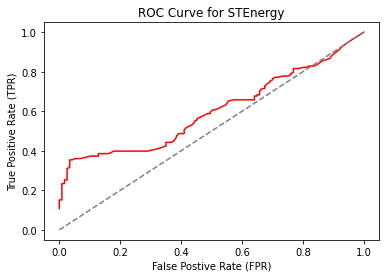

In [8]:
# threshold values
p_compare = np.linspace(0, 1, 1000)

gt = np.array(ground_truth_test)

# true positive rate
tpr_ste = []

# false positive rate
fpr_ste = []

# function for pair-wise comparision and counting
def count(pred, val1, val2):
    sum = 0
    for i in range(0, len(pred)):
        if pred[i] == val1 and gt[i] == val2:
           sum = sum + 1
    return sum

for i in p_compare:

    # compare P(xi|speech) by varying thresholds
    pred = np.where(prob_speech_given_x >= i, 1, 0) # assign 1 (~belongs to speech) to values of P(x|speech) greater than p_compare[i], else 0
    total = pred.size
    
    tp = count(pred, 1, 1) # true positves
    tn = count(pred, 0, 0) # true negatives
    fn = count(pred, 0, 1) # false negatives
    fp = count(pred, 1, 0) # false positives

    tpr_ste.append(tp/(tp+fn))
    fpr_ste.append(fp/(fp+tn))

plt.plot(fpr_ste, tpr_ste, color = 'r') # fpr on x-axis, tpr on y-axis
plt.plot(p_compare, p_compare, color = 'gray', linestyle='--')

plt.title("ROC Curve for STEnergy")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")

plt.show()

    

-------------------------------------------
##**MEL Energy**

###Read Data

In [9]:
X_MEL = pd.read_csv(path+'/Segment2_MelEnergy.csv', header = None)
ground_truth_train = pd.read_csv(path+'/Segment2_VAD_GT.csv', header = None)

X_train_mel = np.array(X_MEL)

speech_train_mel, non_speech_train_mel = split_data(X_train_mel, ground_truth_train)

speech_train_mel.shape, non_speech_train_mel.shape, X_train_mel.shape

((111,), (145,), (256, 1))

###Mean and variance for each Class

In [10]:
# mean and variance for both the classes
mu1_mel, var1_mel = mean_var(speech_train_mel)
mu2_mel, var2_mel = mean_var(non_speech_train_mel)

# standard deviation 
sd1_mel = math.sqrt(var1_mel)
sd2_mel = math.sqrt(var2_mel)

print("Mean, Variance and Standard Deviation for: \n")
print("Speech Training Data - ", mu1_mel, ", ", var1_mel, ", ", sd1_mel)
print("Non-Speech Training Data - ", mu2_mel, ", ", var2_mel, ", ", sd2_mel)


Mean, Variance and Standard Deviation for: 

Speech Training Data -  0.6100466456738739 ,  0.022868307223842404 ,  0.15122270736844518
Non-Speech Training Data -  0.45865463603448275 ,  0.005185428144146614 ,  0.07200991698472241


###Estimate Normal Curve

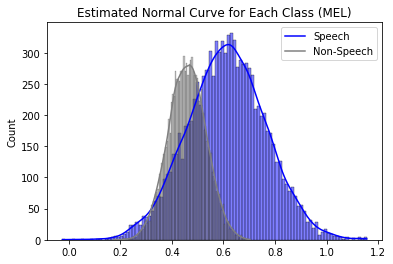

In [11]:
# estimate a normal curve based on the mean and variance of the sample data

val1_mel = np.random.normal(mu1_mel, sd1_mel, 10000)
val2_mel = np.random.normal(mu2_mel, sd2_mel, 10000)

sb.histplot(val1_mel, kde=True, bins = 100, color = "blue")
sb.histplot(val2_mel, kde=True, bins = 100, color = "grey")

plt.title("Estimated Normal Curve for Each Class (MEL)")
plt.legend(["Speech", "Non-Speech"])
plt.show()


###Test the Model

In [12]:
X_test_mel = pd.read_csv(path+'/Segment3_MelEnergy.csv', header = None)

# Ground Truth for testing the model
ground_truth_test = pd.read_csv(path+'/Segment3_VAD_GT.csv', header = None)

# likelihood
prob_x_given_speech_mel = likelihood(mu1_mel, sd1_mel, X_test_mel)
prob_x_given_non_speech_mel = likelihood(mu2_mel, sd2_mel, X_test_mel) 

# prior probability
prob_speech_mel = prior(speech_train_mel, X_train_mel)
prob_non_speech_mel = prior(non_speech_train_mel, X_train_mel)

# P(x) or evidence
evidence_mel = np.add((prob_x_given_speech_mel * prob_speech_mel), (prob_x_given_non_speech_mel * prob_non_speech_mel))

# posterior probability
prob_speech_given_x_mel = posterior(prob_x_given_speech_mel, prob_speech_mel, evidence_mel)

X_test_mel.shape


(275, 1)

###ROC Curve (MEL Energy)

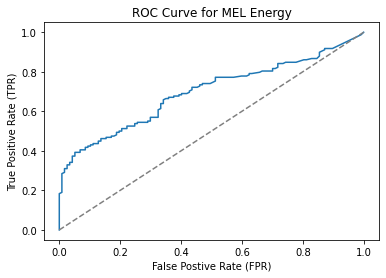

In [13]:
gt = np.array(ground_truth_test)

# true positive rate
tpr_mel = []

# false positive rate
fpr_mel = []

for i in p_compare:

    # compare P(xi|speech) by varying thresholds 
    pred_mel = np.where(prob_speech_given_x_mel >= i, 1, 0)  # assign 1 to values of P(x|speech) greater than p_compare[i], else 0
    total = pred_mel.size
    
    tp_mel = count(pred_mel, 1, 1) # true positves
    tn_mel = count(pred_mel, 0, 0) # true negatives
    fn_mel = count(pred_mel, 0, 1) # false negatives
    fp_mel = count(pred_mel, 1, 0) # false positives

    # calculate true positive rate and false positive rate
    tpr_mel.append(tp_mel/(tp_mel+fn_mel))
    fpr_mel.append(fp_mel/(fp_mel+tn_mel))

plt.plot(fpr_mel, tpr_mel) # fpr on x-axis, tpr on y-axis
plt.plot(p_compare, p_compare, color = 'gray', linestyle='--') # threshold

plt.title("ROC Curve for MEL Energy")
plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")

plt.show()

    

###**Compare ROC Curves (MEL vs STE)**

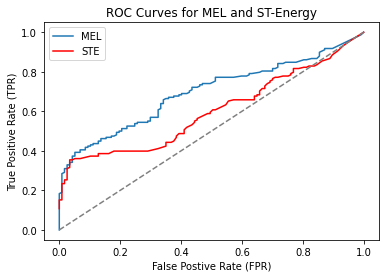

In [14]:

plt.plot(fpr_mel, tpr_mel)
plt.plot(fpr_ste, tpr_ste, color = 'r')
plt.plot(p_compare, p_compare, color = 'gray', linestyle='--')

plt.legend(["MEL", "STE"])
plt.title("ROC Curves for MEL and ST-Energy")

plt.xlabel("False Postive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

####Conclusion: MEL Energy gives better results as compared to ST-Energy